In [1]:
%pylab inline
import pandas as pd
import seaborn as sns

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Set the size of plots to a large size
plt.rcParams["figure.figsize"] = (20,1)

Populating the interactive namespace from numpy and matplotlib


# Logistic Regression

> Contributors: Eric Keränen, Samuel Aitamaa & Teemu Luhtanen

The goal of this assignment is to make a diagnostic tool (not for real medical use) that asks a medical expert six
numerical quantities obtained by radiographic measurements of a patient. 
As an output, your program should provide a probability estimate of the patient having a
vertebral abnormality (either disk hernia or spondylolisthesis). Alternatively, your tool can not
only indicate abnormality but also specify which of the two conditions an affected individual is
likely to have.

## Part I - Input

Hello, medical expert! Here you can input six different numerical quantities to determine if an individual has a vertebral abnormality. Remember to give the inputs as whole numbers or decimal point numbers, no strings allowed!  
Go ahead, try it:

In [2]:
questions = ['pelvic incidence', 'pelvic tilt', 'lumbar lordosis angle', 'sacral slope', 'pelvic radius', 'grade of spondylolisthesis']
answers = {}

for question in questions:
    answers[question] = float(input(f"Enter {question}: "))

answers = pd.DataFrame(answers, index=[0])

Enter pelvic incidence:  60.12
Enter pelvic tilt:  30.87
Enter lumbar lordosis angle:  50.01
Enter sacral slope:  40.69
Enter pelvic radius:  120.55
Enter grade of spondylolisthesis:  40.02


Once you have inputted the numerical values, you can scroll to the end of the notebook to **Part IV** to find out what exciting diagnose you've discovered!

## Part II - Preprocess and computing

In [3]:
df = pd.read_csv('abnormality.csv', sep=',')
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,60.50,17.24,26.15,46.43,58.69,72.88,129.83
pelvic_tilt,310.0,17.54,10.01,-6.55,10.67,16.36,22.12,49.43
lumbar_lordosis_angle,310.0,51.93,18.55,14.00,37.00,49.56,63.00,125.74
sacral_slope,310.0,42.95,13.42,13.37,33.35,42.40,52.70,121.43
pelvic_radius,310.0,117.92,13.32,70.08,110.71,118.27,125.47,163.07
degree_spondylolisthesis,310.0,26.30,37.56,-11.06,1.60,11.77,41.29,418.54


In [4]:
df.dtypes

pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
diagnose                     object
dtype: object

The dataset does not have missing values and all the data is in <code>float</code> form already, except for the diagnose, which is an object containing values <code>NORMAL</code> and <code>ABNORMAL</code>. For these we will change the values to *0* and *1*, zero corresponding a normal diagnose and one corresponding abnormal.

In [5]:
# Replace diagnoses with numerical values
# Normal is identified as 0 and abnormal is identified as 1
df["diagnose"].replace({"Normal": 0, "Abnormal": 1}, inplace=True)

In [6]:
# Extract data into labels, features and column names
labels = df["diagnose"]
features = df.drop("diagnose", axis = 1)
colnames = features.columns

features.tail(5).round(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
305,47.90,13.62,36.00,34.29,117.45,-4.25
306,53.94,20.72,29.22,33.22,114.37,-0.42
307,61.45,22.69,46.17,38.75,125.67,-2.71
308,45.25,8.69,41.58,36.56,118.55,0.21
309,33.84,5.07,36.64,28.77,123.95,-0.20


In [7]:
# Scale data
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns = colnames)

features.tail(5).round(2)

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
305,-0.73,-0.39,-0.86,-0.65,-0.04,-0.81
306,-0.38,0.32,-1.23,-0.73,-0.27,-0.71
307,0.06,0.52,-0.31,-0.31,0.58,-0.77
308,-0.89,-0.89,-0.56,-0.48,0.05,-0.70
309,-1.55,-1.25,-0.83,-1.06,0.45,-0.71


The data has some fluctuation between columns, so we will scale it with <code>sklearn.preprocessing.StandardScaler()</code> to ease comparing the values between each other.

<AxesSubplot:>

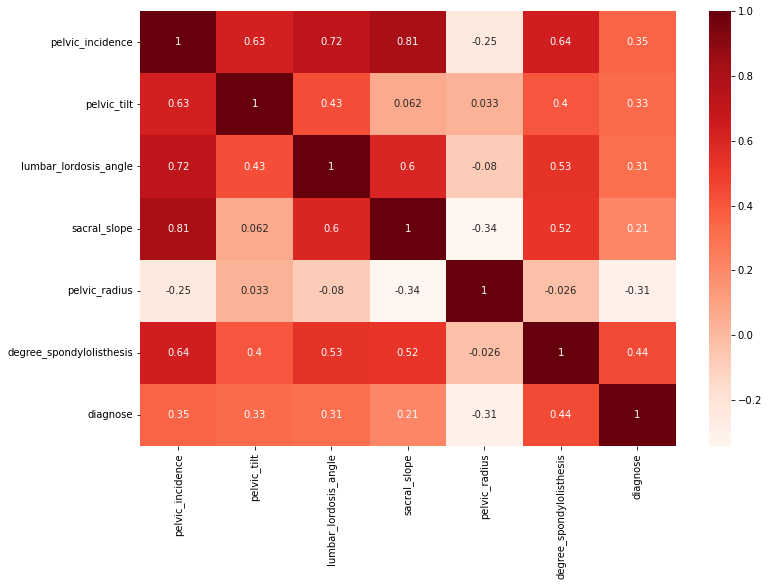

In [8]:
corr = df.corr(method="pearson")
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="Reds", annot=True)

Here we can see a heatmap and every variables relation to each other. For example, we can see that <code>sacral_slope</code> and <code>pelvic_incidence</code> are highly correlated. In fact, most of the variables are correlated to each other quite highly. However, as we have only six columns, we decided to not delete any from the dataset.

In [9]:
# Make model and fit it
reg = linear_model.LogisticRegression()
reg.fit(features, labels)

# Get the coefficients and intercept value
print("Coefficients:")
for (index, coef) in enumerate(reg.coef_[0]):
    print (f"{colnames[index]:25s} : {round(coef, 4)}")
print("\nIntercept:", reg.intercept_[0])

Coefficients:
pelvic_incidence          : -0.1849
pelvic_tilt               : 0.6879
lumbar_lordosis_angle     : -0.1539
sacral_slope              : -0.7503
pelvic_radius             : -1.1323
degree_spondylolisthesis  : 4.0671

Intercept: 2.167410451970614


From the coefficients we can see that <code>degree_spondylolisthesis</code> as well as <code>pelvic_radius</code> have the most impact on determining the diagnose. <code>degree_spondylolisthesis</code> raises the chance of abnormality and <code>pelvic_radius</code> lowers the chance of abnormality.

## Part III - Validation and evaluation

Before validating the data, we got ~85.8 % accuracy for the trained data.

In [10]:
reg.score(features, labels)

0.8580645161290322

We decided to use cross validation because it is [better for smaller datasets](https://stackoverflow.com/questions/37003095/when-to-use-k-fold-cross-validation-and-when-to-use-split-percentage) like ours (only 310 instances).  
After validation, the accuracy was 82 %. We used cross validation (with 10 folds) to validate the data.

In [11]:
# Cross-validate the data
k = 10
scores = cross_val_score(estimator = reg, X = features, y = labels, scoring = "accuracy", cv = k)
print(f"Accuracies from {k} individual folds")
for score in scores:
    print(round(score * 100,4), '%')
print(f"Accuracy calculated using {k}-fold cross validation = {scores.mean():.2}")

Accuracies from 10 individual folds
58.0645 %
61.2903 %
80.6452 %
77.4194 %
90.3226 %
93.5484 %
93.5484 %
90.3226 %
80.6452 %
93.5484 %
Accuracy calculated using 10-fold cross validation = 0.82


## Part IV - Results From Input

Here you can see the results from the inputs that have been given in **Part I**. Below you can see how the model has determined if the patient is afflicted or not (abnormal or not) with an input of:

|Input|Value|
|---|---|
|pelvic incidence|60.12|
|pelvic tilt|30.87|
|lumbar lordosis angle|50.01|
|sacral slope|40.69|
|pelvic radius|120.55|
|grade of spondylolisthesis|40.02|

Try it out with your own inputs to see which kind of diagnose does it produce!

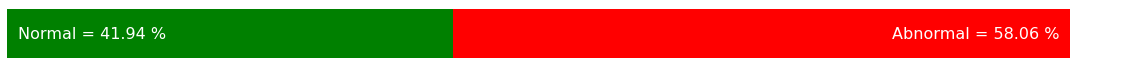

In [12]:
prediction = reg.predict(answers)
prediction_probability = reg.predict_proba(answers)

plt.axis('off')

Class = ["Diagnose"]
First = [prediction_probability[0][0] * 100]
Second = [prediction_probability[0][1] * 100]

plt.barh(Class, First, 0.2, color="green")
plt.barh(Class, Second, 0.2, left=First, color="red")
plt.text(1,0, f"Normal = {round(First[0],2)} %", ha = "left", va = "center", color = "white", fontsize = 16)
plt.text(99,0, f"Abnormal = {round(Second[0],2)} %", ha = "right", va = "center", color = "white", fontsize = 16)
plt.show()

The model has come to a conclusion that there is a 41.94 % probability that the individual is does not have any afflictions regarding vertebral abnormality and a 58.06 % probability of having one. Because the percetage is higher for the abnormal rate, the conclusion is that the individual has an abnormality.

In [13]:
diagnose = "ABNORMAL" if prediction[0] else "NORMAL"
print (f"YOUR DIAGNOSE IS: {diagnose}")

YOUR DIAGNOSE IS: ABNORMAL
